# Lessons from Binary Classification

## Performance Evaluation, Surrogate Losses, and Class Weighting

James Sharpnack<br>
Assistant Professor<br>
UC Davis, Statistics Department<br>
5/5/2017<br>

__Talk Outline__
1. Introduction with link prediction in social networks
1. Evaluating a score with ROC and PR curves
1. Multiple predictors and hyperplane methods
1. Surrogate Losses
1. Class weights

## Link Prediction in Social Networks

In [633]:
import pandas as pd
import numpy as np
import networkx as nx
import os
from scipy import sparse as sp
from matplotlib import pyplot as plt
from sklearn import metrics as skmetrics
from sklearn.linear_model import LogisticRegression
import itertools
from sklearn.svm import SVC
%matplotlib inline
plt.style.use('ggplot')

In [634]:
n = 347
p = .1
testind = np.random.rand(n**2)
testind = testind < p 
testind = testind.reshape((n,n))
test_isp = sp.lil_matrix((n,n))
W_test = sp.lil_matrix((n,n))
W_train = sp.lil_matrix((n,n))

In [688]:
# The following imports the facebook graph and splits the edges into a training and a test set

facedir = './'
efnames = [f for f in os.listdir(facedir) if 'edges' in f]
g_train = nx.Graph()
g_test = nx.Graph()
for efname in efnames:
    ELdf = pd.read_csv(facedir+efname,sep=' ',header=None)
    eliter = ELdf.iterrows()
    for e in eliter:
        i,j = tuple(e[1])
        if i < j:
            test_isp[i-1,j-1] = True
            if not testind[i-1,j-1]:
                g_train.add_edge(i-1,j-1)
                W_train[i-1,j-1] = 1
            else:
                g_test.add_edge(i-1,j-1)
                W_test[i-1,j-1] = 1

In [636]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Code from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [637]:
m_test = g_test.number_of_edges()
m_train = g_train.number_of_edges()

In [638]:
print m_train, m_test

2260 259


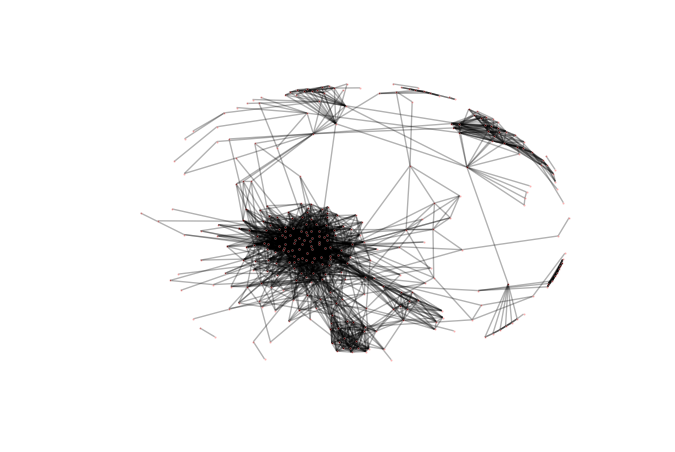

In [639]:
nx.draw(g_train,node_size=2,alpha=.3)

__Training Facebook graph__ with 347 vertices and 2267 edges.  The original dataset can be found at the SNAP project website: https://snap.stanford.edu/data/egonets-Facebook.html

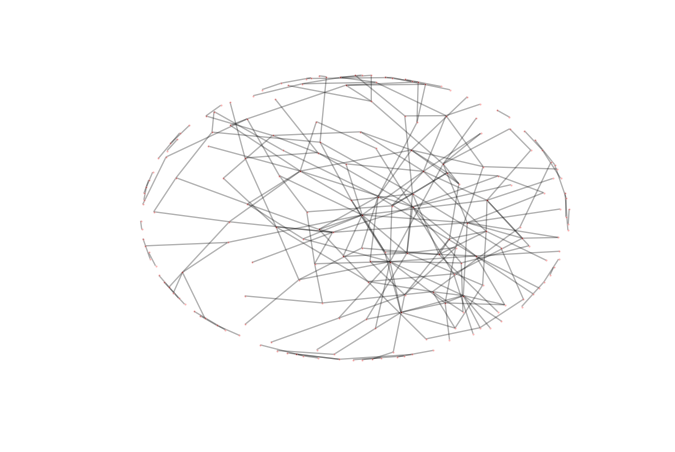

In [640]:
nx.draw(g_test,node_size=2,alpha=.3)

__Testing Facebook graph__ with 347 vertices and 252 edges.  The original dataset can be found at the SNAP project website: https://snap.stanford.edu/data/egonets-Facebook.html

## Evaluating a Score with ROC and PR Curves 

In [641]:
i,j = 0,3
print set(g_train.neighbors(i))
print set(g_train.neighbors(j))
print set(g_train.neighbors(i)) & set(g.neighbors(j))

set([279, 321, 132, 72, 298, 235, 47, 52, 53, 118, 87, 345, 125])
set([194, 327, 77, 305, 274, 180, 151, 217])
set([72])


In [642]:
P1 = W_train.dot(W_train)

In [643]:
Itest, Jtest, _ = sp.find(testind)

In [644]:
m = len(Itest)
z = np.array(P1[Itest,Jtest]).reshape(m)
y = W_test[Itest,Jtest].toarray().reshape(m)

In [645]:
z.shape, y.shape

((11973L,), (11973L,))

Confusion matrix, without normalization
[[11187   527]
 [   64   195]]


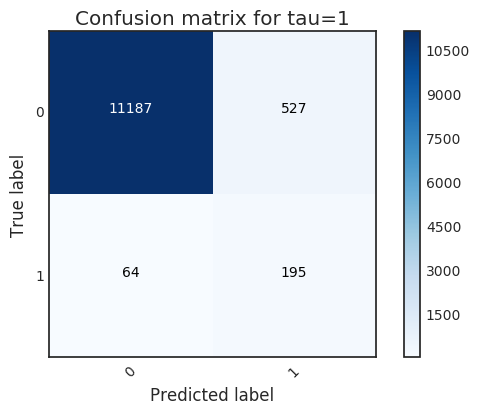

In [646]:
tau = 1
with plt.style.context(('seaborn-white')):
    plot_confusion_matrix(skmetrics.confusion_matrix(y,z>=tau),[0,1],
                      title="Confusion matrix for tau={}".format(tau))

Confusion matrix, without normalization
[[11666    48]
 [  201    58]]


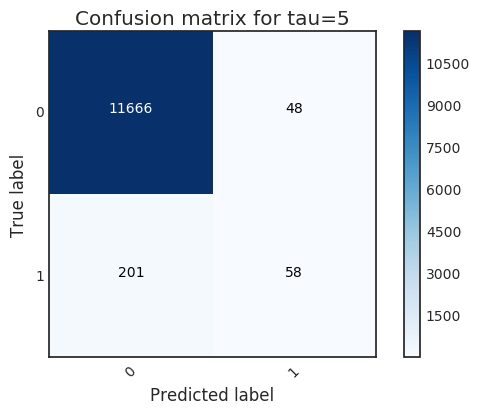

In [647]:
tau = 5
with plt.style.context(('seaborn-white')):
    plot_confusion_matrix(skmetrics.confusion_matrix(y,z>=tau),[0,1],
                      title="Confusion matrix for tau={}".format(tau))

Confusion matrix, without normalization
[[11707     7]
 [  244    15]]


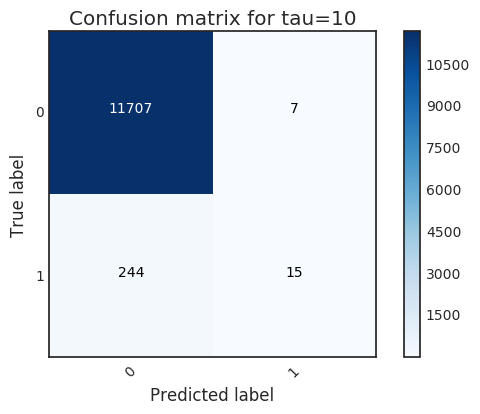

In [648]:
tau = 10
with plt.style.context(('seaborn-white')):
    plot_confusion_matrix(skmetrics.confusion_matrix(y,z>=tau),[0,1],
                      title="Confusion matrix for tau={}".format(tau))

In [649]:
prec, rec, taus = skmetrics.precision_recall_curve(y,z)
prec_rand, rec_rand, _ = skmetrics.precision_recall_curve(y,np.random.rand(m))

In [650]:
for p,t in zip(prec, taus):
    print "tau: {}, prec: {}".format(t,p)

tau: 0.0, prec: 0.0216320053454
tau: 1.0, prec: 0.270083102493
tau: 2.0, prec: 0.400516795866
tau: 3.0, prec: 0.448559670782
tau: 4.0, prec: 0.5
tau: 5.0, prec: 0.547169811321
tau: 6.0, prec: 0.616438356164
tau: 7.0, prec: 0.642857142857
tau: 8.0, prec: 0.641025641026
tau: 9.0, prec: 0.7
tau: 10.0, prec: 0.681818181818
tau: 11.0, prec: 0.722222222222
tau: 12.0, prec: 0.733333333333
tau: 13.0, prec: 0.666666666667
tau: 15.0, prec: 0.777777777778
tau: 16.0, prec: 0.75
tau: 18.0, prec: 0.714285714286
tau: 19.0, prec: 0.666666666667
tau: 23.0, prec: 0.75
tau: 26.0, prec: 1.0
tau: 27.0, prec: 1.0


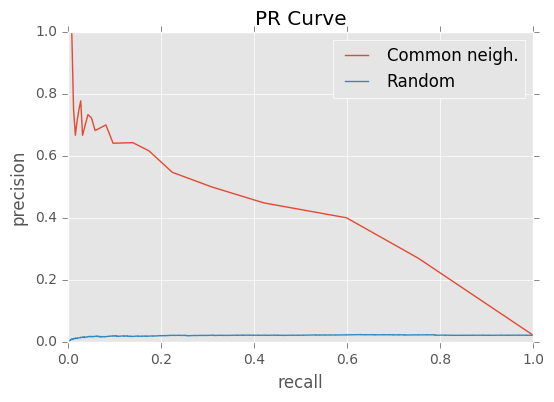

In [651]:
_ = plt.plot(rec,prec,label='Common neigh.')
_ = plt.plot(rec_rand,prec_rand,label='Random')
_ = plt.title('PR Curve')
_ = plt.xlabel('recall')
_ = plt.ylabel('precision')
_ = plt.legend()

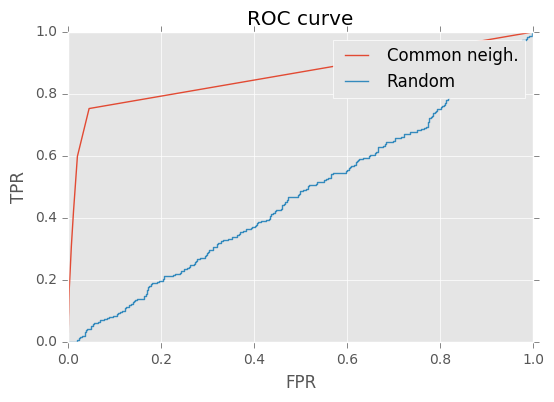

In [652]:
fpr, tpr, _ = skmetrics.roc_curve(y,z)
fpr_rand, tpr_rand, _ = skmetrics.roc_curve(y,np.random.rand(m))

_ = plt.plot(fpr,tpr,label='Common neigh.')
_ = plt.plot(fpr_rand,tpr_rand,label='Random')
_ = plt.title('ROC curve')
_ = plt.xlabel('FPR')
_ = plt.ylabel('TPR')
_ = plt.legend()

In [653]:
W = W_train.copy()

In [654]:
ds = np.array(W.sum(axis=1)).reshape(n)
dinv = ds.copy()
dinv[ds>0] = ds[ds>0]**(-1)

In [655]:
X = []
#P = np.diag(dinv).dot(W_train.toarray())
P = W_train.toarray()
Ppow = P.dot(P)
for k in xrange(6):
    Ppow = Ppow.dot(P)
    x = np.array(Ppow[Itest,Jtest]).reshape(m)
    X.append(np.log(x+1.))
X = np.array(X).T

In [656]:
y = W_test[Itest,Jtest].toarray().reshape(m)

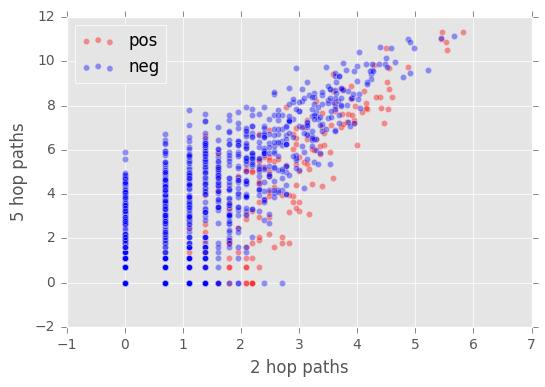

In [657]:
_ = plt.scatter(X[y==1,0],X[y==1,3],c='r',alpha=.4,label='pos')
_ = plt.scatter(X[y==0,0],X[y==0,3],c='b',alpha=.4,label='neg')
_ = plt.xlabel('2 hop paths')
_ = plt.ylabel('5 hop paths')
_ = plt.legend(loc=2)

In [658]:
lr = LogisticRegression()
lr.fit(X[:,[0,3]],y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [659]:
beta1 = lr.coef_[0,0]
beta3 = lr.coef_[0,1]
beta0 = lr.intercept_

T = np.linspace(1,5.5,100)
x3hat = -(beta0 + beta1*T) / beta3

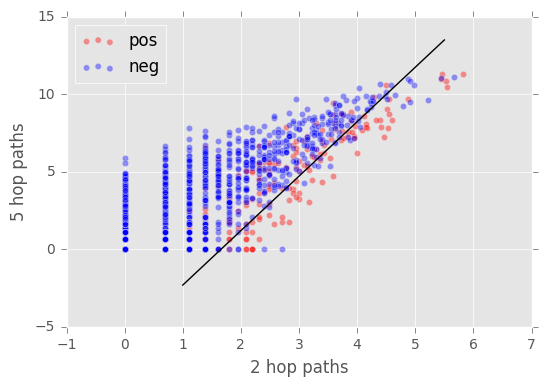

In [660]:
_ = plt.scatter(X[y==1,0],X[y==1,3],c='r',alpha=.4,label='pos')
_ = plt.scatter(X[y==0,0],X[y==0,3],c='b',alpha=.4,label='neg')
_ = plt.plot(T,x3hat,c='k')
_ = plt.xlabel('2 hop paths')
_ = plt.ylabel('5 hop paths')
_ = plt.legend(loc=2)

Confusion matrix, without normalization
[[11683    31]
 [  191    68]]


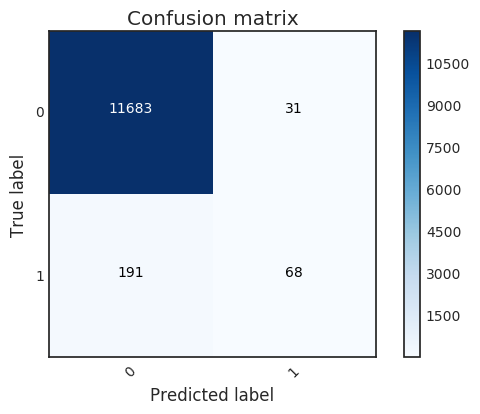

In [661]:
lr = LogisticRegression()
lr.fit(X,y)
z_log = lr.predict_proba(X)[:,1]
with plt.style.context(('seaborn-white')):
    plot_confusion_matrix(skmetrics.confusion_matrix(y,z_log>0.5),[0,1])

[]

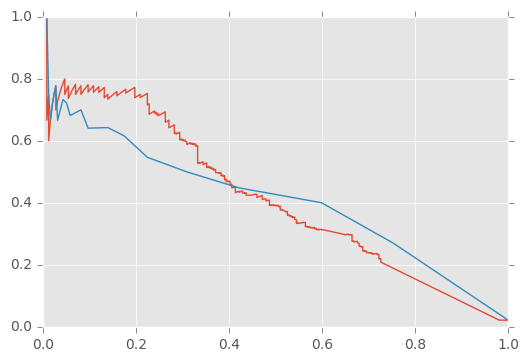

In [662]:
prec_log, rec_log, _ = skmetrics.precision_recall_curve(y,z_log)
plt.plot(rec_log,prec_log)
plt.plot(rec,prec)
plt.plot()

## Finding a hyperplane

In [663]:
N = 100
X1 = (np.random.randn(N*2)).reshape((N,2)) + np.array([2,3])
X0 = (np.random.randn(N*2)).reshape((N,2)) + np.array([.5,1.5])
y = np.zeros(N*2)
y[:N]=1
X = np.vstack((X1,X0))

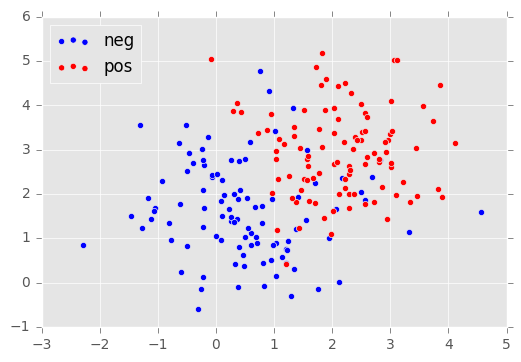

In [664]:
_ = plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
_ = plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
_ = plt.legend(loc=2)

In [665]:
lr = LogisticRegression()
lr.fit(X,y)

beta1 = lr.coef_[0,0]
beta2 = lr.coef_[0,1]
beta0 = lr.intercept_

mults=0.8
T = np.linspace(-1,4,100)
x2hat = -(beta0 + beta1*T) / beta2
line1 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)
line2 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)
line3 = -(beta0 + np.random.randn(1)*2 + 
          (beta1 + np.random.randn(1)*mults) *T) / (beta2 + np.random.randn(1)*mults)

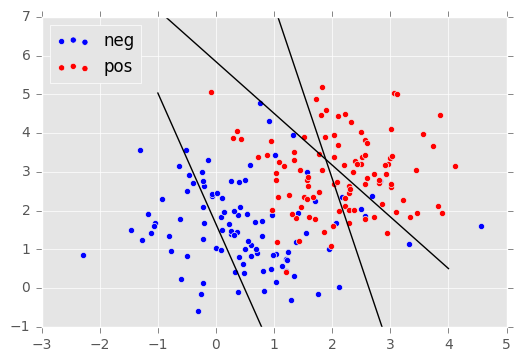

In [666]:
_ = plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
_ = plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
_ = plt.plot(T,line3,c='k')
_ = plt.plot(T,line1,c='k')
_ = plt.plot(T,line2,c='k')
_ = plt.ylim([-1,7])
_ = plt.legend(loc=2)

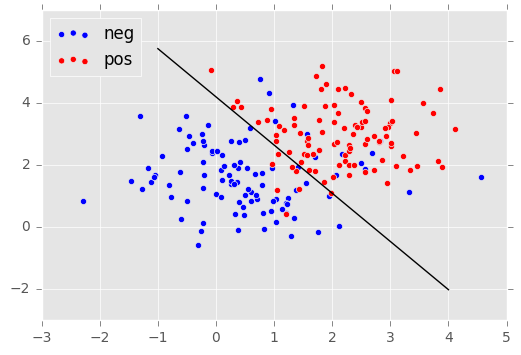

In [667]:
y_hat = lr.predict(X)
_ = plt.scatter(X0[:,0],X0[:,1],c='b',label='neg')
_ = plt.scatter(X1[:,0],X1[:,1],c='r',label='pos')
_ = plt.plot(T,x2hat,c='k')
_ = plt.legend(loc=2)

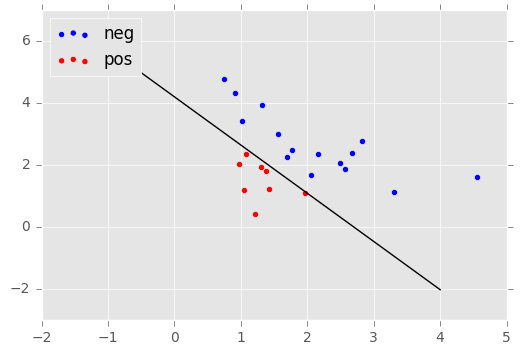

In [668]:
y_hat = lr.predict(X)
_ = plt.scatter(X0[y_hat[N:] == 1,0],X0[y_hat[N:] == 1,1],c='b',label='neg')
_ = plt.scatter(X1[y_hat[:N] == 0,0],X1[y_hat[:N] == 0,1],c='r',label='pos')
_ = plt.plot(T,x2hat,c='k')
_ = plt.legend(loc=2)

## Surrogate Losses

In [669]:
z_range = np.linspace(-5,5,200)

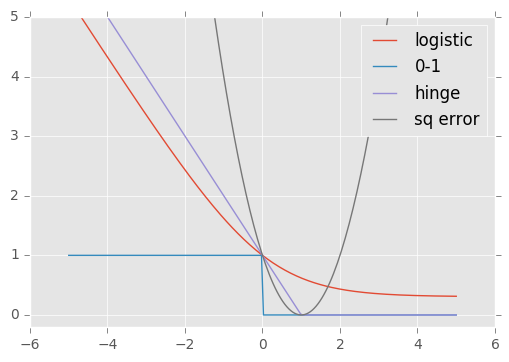

In [670]:
zoloss = z_range < 0
l2loss = (1-z_range)**2.
hingeloss = (1 - z_range) * (z_range < 1)
logisticloss = np.log(1 + np.exp(-z_range))
_ = plt.plot(z_range, logisticloss + 1 - np.log(2.),label='logistic')
_ = plt.plot(z_range, zoloss,label='0-1')
_ = plt.plot(z_range, hingeloss,label='hinge')
_ = plt.plot(z_range, l2loss,label='sq error')
_ = plt.ylim([-.2,5])
_ = plt.title('')
_ = plt.legend()

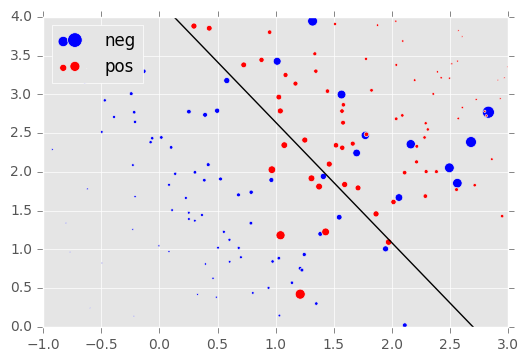

In [671]:
y_hat = lr.predict(X)
z_log = (2.*y - 1.)*lr.decision_function(X)
logisticloss = np.log(1 + np.exp(-z_log))
_ = plt.scatter(X0[:,0],X0[:,1],s=logisticloss[N:]*30.,c='b',label='neg')
_ = plt.scatter(X1[:,0],X1[:,1],s=logisticloss[:N]*30.,c='r',label='pos')
_ = plt.plot(T,x2hat,c='k')
_ = plt.xlim([-1,3])
_ = plt.ylim([0,4])
_ = plt.legend(loc=2)

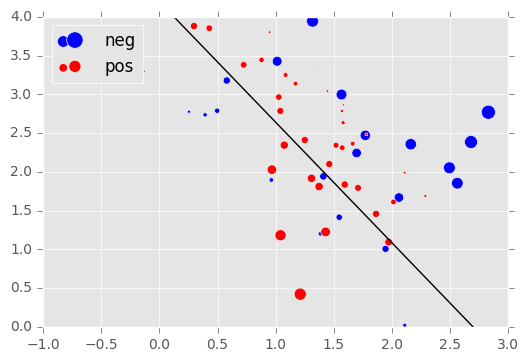

In [672]:
y_hat = lr.predict(X)
z_log = (2.*y - 1.)*lr.decision_function(X)
hingeloss = (1-z_log)*(z_log < 1)
_ = plt.scatter(X0[:,0],X0[:,1],s=hingeloss[N:]*30.,c='b',label='neg')
_ = plt.scatter(X1[:,0],X1[:,1],s=hingeloss[:N]*30.,c='r',label='pos')
_ = plt.plot(T,x2hat,c='k')
_ = plt.xlim([-1,3])
_ = plt.ylim([0,4])
_ = plt.legend(loc=2)

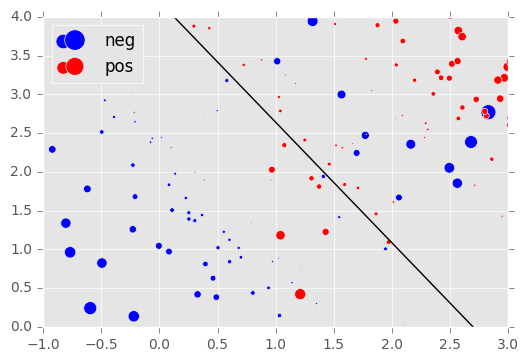

In [673]:
y_hat = lr.predict(X)
z_log = (2.*y - 1.)*lr.decision_function(X)
l2loss = (1-z_log)**2.
_ = plt.scatter(X0[:,0],X0[:,1],s=l2loss[N:]*10.,c='b',label='neg')
_ = plt.scatter(X1[:,0],X1[:,1],s=l2loss[:N]*10.,c='r',label='pos')
_ = plt.plot(T,x2hat,c='k')
_ = plt.xlim([-1,3])
_ = plt.ylim([0,4])
_ = plt.legend(loc=2)

## Class Weighting

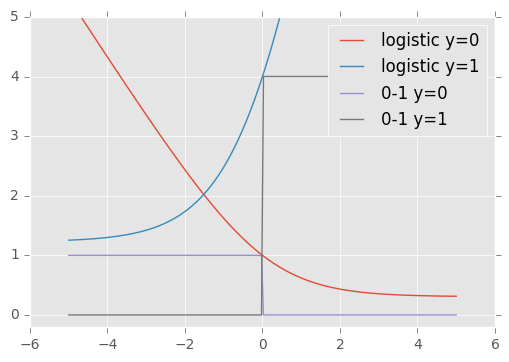

In [674]:
alpha = 4.
zolossn = z_range < 0
zolossp = z_range > 0
logisticlossn = np.log(1 + np.exp(-z_range))
logisticlossp = np.log(1 + np.exp(z_range))
_ = plt.plot(z_range, logisticlossn + 1 - np.log(2.),label='logistic y=0')
_ = plt.plot(z_range, alpha*(logisticlossp + 1 - np.log(2.)),label='logistic y=1')
_ = plt.plot(z_range, zolossn,label='0-1 y=0')
_ = plt.plot(z_range, alpha*zolossp,label='0-1 y=1')
_ = plt.ylim([-.2,5])
_ = plt.title('')
_ = plt.legend()

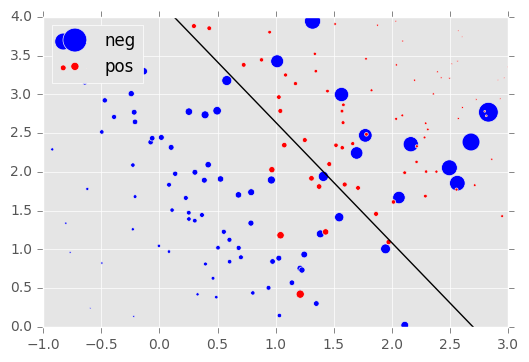

In [675]:
y_hat = lr.predict(X)
z_log = (2.*y - 1.)*lr.decision_function(X)
logisticloss = np.log(1 + np.exp(-z_log))
_ = plt.scatter(X0[:,0],X0[:,1],s=alpha*logisticloss[N:]*20.,c='b',label='neg')
_ = plt.scatter(X1[:,0],X1[:,1],s=logisticloss[:N]*20.,c='r',label='pos')
_ = plt.plot(T,x2hat,c='k')
_ = plt.xlim([-1,3])
_ = plt.ylim([0,4])
_ = plt.legend(loc=2)

In [676]:
lr = LogisticRegression(class_weight='balanced')
lr.fit(X,y)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

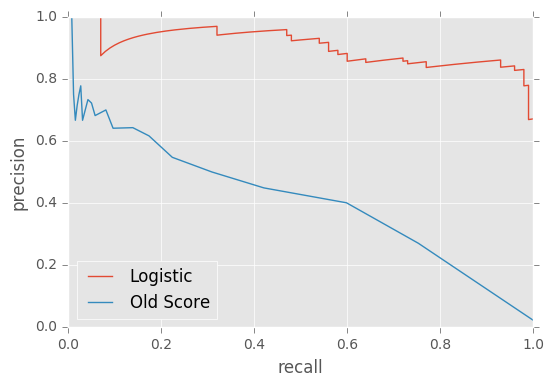

In [685]:
z_log = lr.predict_proba(X)[:,1]
prec_log, rec_log, _ = skmetrics.precision_recall_curve(y,z_log)
_ = plt.plot(rec_log,prec_log,label='Logistic')
_ = plt.plot(rec,prec,label='Old Score')
_ = plt.xlabel('recall')
_ = plt.ylabel('precision')
_ = plt.legend(loc=3)
_ = plt.plot()

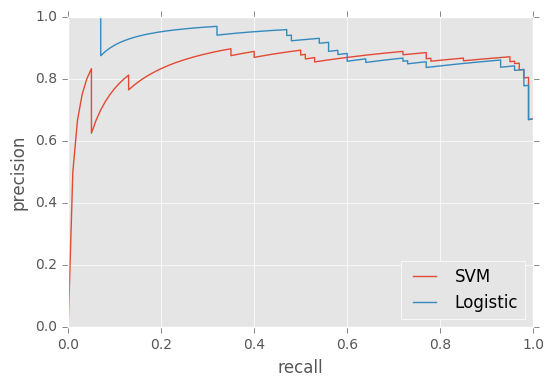

In [686]:
svc = SVC(class_weight='balanced')
svc.fit(X,y)
z_svm = svc.decision_function(X)
prec_svm, rec_svm, _ = skmetrics.precision_recall_curve(y,z_svm)
_ = plt.plot(rec_svm,prec_svm,label='SVM')
_ = plt.plot(rec_log,prec_log,label='Logistic')
_ = plt.xlabel('recall')
_ = plt.ylabel('precision')
_ = plt.legend(loc=4)
_ = plt.plot()